In [1]:
import numpy as np
import random as rnd
import copy
from matplotlib import pyplot as plt

In [2]:
class Garnet:
    def __init__(self, Ns, Na, Nb, d, gamma):
        # Ns: number of states, Na: number of actions in each state, Nb: branching factor
        # gamma: discount factor, d: dimension of feature vector
        self.Ns = Ns
        self.Na = Na
        self.Nb = Nb
        self.gamma = gamma
        self.d = d
        self.initGarnet()
    
    # initialize garnet
    def initGarnet(self):
        self.initTransition()
        self.initReward()
        self.initPi()
        self.initPhi()
        
    #------------------------   
    # initializers
    def initTransition(self):
        # P: s x a x s'
        P = np.zeros((self.Ns, self.Na, self.Ns))
        for i in range(self.Ns):
            for j in range(self.Na):
                sampleArr = rnd.sample(range(self.Ns), k = self.Nb)
                P_sum = np.random.rand(self.Nb - 1)
                P_sum = np.sort([*P_sum, 0, 1])
                for k in range(self.Nb):
                    P[i][j][sampleArr[k]] = P_sum[k + 1] - P_sum[k]
        self.P = P                                            
    
    def initReward(self):
        # R: s x a, uniform random
        self.R = np.random.uniform(size=(self.Ns, self.Na))
    
    def initPi(self):
        # pi: s x a, uniform random
        self.pi = np.ones((self.Ns, self.Na)) / self.Na
        
    def initPhi(self, mean=0):
        # linear function approximation on policy function
        # phi: s x a x d, w (weight vector): d x 1
        self.Phi = np.random.normal(loc=mean,size=(self.Ns, self.Na, self.d))
        self.w = np.zeros((self.d,1))
        self.calPolicy()
    
    #------------------------   
    # calculate true state values given a policy
    def calValue(self):   
        # P_pi: s x s', R_pi: s x 1
        P_pi = np.einsum('ijk,ij->ik', self.P, self.pi)
        R_pi = np.einsum('ij,ij->i', self.pi, self.R)
        self.P_pi = P_pi
        self.R_pi = R_pi
        self.V_pi = np.linalg.inv(np.identity(self.Ns) - self.gamma * P_pi).dot(R_pi)
        return self.V_pi
    
    # calculate the average value given a policy
    def calAvgReward(self):
        self.calValue()
        e, v = np.linalg.eig(self.P_pi.T)
        mu = v[:,0] # eigenvector
        mu = mu / mu.sum()  # scale to make sum 1
        return self.R_pi.dot(mu).real
    
    # calculate the linear function approximation on policy function
    def calPolicy(self):
        pi_ = np.einsum('ijk,kl->ij', self.Phi, self.w)
        pi = np.exp(pi_) / np.exp(pi_).sum(axis=1, keepdims = True)
        self.pi = pi
    
    # calculate the logarithm of the policy gradient given s, a
    def calLogPiGradient(self, s, a):
        return (self.Phi[s,a] - np.einsum('ij,i->j',g.Phi[5],g.pi[5])).reshape(self.d, -1)
    
    #------------------------
    # get next state from current state
    def getNext(self, s):
        a = self.getAction(s)
        r = self.R[s,a]
        s_next = self.getState(s,a)
        return a, r, s_next
    
    # get action according to pi given s
    def getAction(self, s):
        return np.random.choice(np.arange(self.Na),p=self.pi[s,:])
    
    # get next state accoding to P given s, a
    def getState(self, s, a):
        return np.random.choice(np.arange(self.Ns), p=self.P[s,a,:])
    
    # generate an episode of length T
    def genEpisode(self, T):
        S = np.ndarray((T+1), int)
        A = np.ndarray((T), int)
        r = np.ndarray((T), float)
        S[0] = np.random.randint(0, self.Na - 1)
        for t in range(T):
            A[t], r[t], S[t+1] = self.getNext(S[t])
        return S, A, r
    
    #------------------------
    # Algorithm 1: “REINFORCE” algorithm
    # generate one iteration
    def pgIter(self, T, alpha):
        S, A, r = self.genEpisode(T)
        for t in range(T):
            G = 0
            for i in range(T-t):
                G += (self.gamma ** i) * r[t+i]
            self.w = (self.w + alpha * (self.gamma ** t) * G * self.calLogPiGradient(S[t], A[t]))
            for i in range(self.d):
                if self.w[i] < 0:
                    # to prevent divide by 0
                    self.w[i] = 1e-10
            # update policy after w has been updated
            self.calPolicy()
    
    # driver function
    def REINFORCE(self, T, count):
        AvgRewardList = np.ndarray((count+1), float)
        AvgRewardList[0] = self.calAvgReward()
        for i in range(count):
            # diminishing step size
            alpha = 0.01 / (i + 1)
            self.pgIter(T, alpha)
            AvgRewardList[i+1] = self.calAvgReward()
        # graph plotting to present the result
        plt.plot(range(0, (count+1) * T, T), AvgRewardList)
        plt.title("Average Reward of “REINFORCE” Algorithm")
        plt.ylabel("Average Reward")
        plt.xlabel("Number of Sample Used")
        
    #------------------------
    # Algorithm 2: online policy gradient algorithm
    def pgOnline(self, alpha, lambd, T, ir):
        # initial setup
        if not hasattr(self, 'G'):
            self.G = np.zeros(self.w.shape)
        if not hasattr(self, 's'):
            self.s = np.random.randint(self.Ns)
        s = self.s
        avgRs = []
        Ts = []
        for t in range(T):
            a, r, s_next = self.getNext(s)
            grad = self.calLogPiGradient(s, a)
            self.G = lambd * self.G + grad
            self.w = self.w + alpha / (t + 10) * r * self.G
            # update policy after w has been updated
            self.calPolicy()
            if (t + 1) % (T // ir) == 0:
                avgR = self.calAvgReward()
                avgRs.append(avgR)
                Ts.append(t + 1)
        self.s = s
        # graph plotting to present the result
        plt.plot(Ts, avgRs)
        plt.title("Average Reward of Online Policy Gradient Algorithm")
        plt.xlabel('Number of Sample Used')
        plt.ylabel("Average Reward")
        plt.show()

In [3]:
g = Garnet(10, 5, 2, 10, 0.9)
g1 = copy.deepcopy(g)
g2 = copy.deepcopy(g)

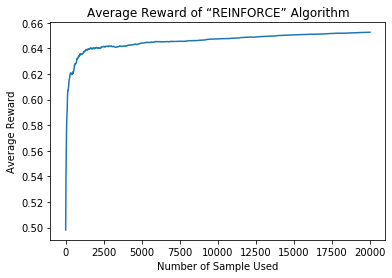

In [4]:
# "REINFORCE" Algorithm testing
g1.REINFORCE(20, 1000)

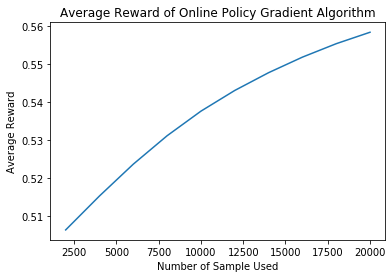

In [5]:
# Online Policy Gradient Algorithm testing
g2.pgOnline(1e-4, 1-1e-4, 20000, 10)